<a href="https://colab.research.google.com/github/Isi2000/PATTERN/blob/main/Classificaition_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [67]:
#data an and plotting 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import random

#torch 
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms.functional as Ft

import torch.nn as nn
import torch.nn.functional as F

from torchvision import transforms
from torchvision.io import read_image
from torchsummary import summary
import torch.optim as optim
#working with dirs
import os


In [68]:
#this line of code copies the files in the PATTERN repo
#they are hd image so it may take a while
!git clone https://github.com/Isi2000/PATTERN.git

fatal: destination path 'PATTERN' already exists and is not an empty directory.


# DATASET

First the image paths and labels need to be storged in a pd DataFrame object to later be put in a custom made dataset 

In [69]:
labels_map = {0: 'NORMAL', 1:'BACTERIAL', 2:'VIRAL',}

data_dir_train = '/content/PATTERN/images/t_all'
data_dir_test = '/content/PATTERN/images/test_all'
data_dir_val = '/content/PATTERN/images/val_all'

d_train = {'img_path': os.listdir(data_dir_train)}
d_test = {'img_path': os.listdir(data_dir_test)}
d_val = {'img_path': os.listdir(data_dir_val)}

df_train = pd.DataFrame(d_train)
df_test= pd.DataFrame(d_test)
df_val = pd.DataFrame(d_val)

df_train['label'] = 0
df_test['label'] = 0
df_val['label'] = 0

#these lines work really well, BE CAREFUL BECAUSE IT GIVES A PD WARNING 

#DIOCANE
df_train.loc[df_train['img_path'].str.contains('virus'), 'label'] = 2
df_train.loc[df_train['img_path'].str.contains('bacte'), 'label'] = 1
df_test.loc[df_test['img_path'].str.contains('virus'), 'label'] = 2
df_test.loc[df_test['img_path'].str.contains('bacte'), 'label'] = 1
df_val.loc[df_val['img_path'].str.contains('virus'), 'label'] = 2
df_val.loc[df_val['img_path'].str.contains('bacte'), 'label'] = 1

print(df_train.head())
print(df_test.head())
print(df_val.head())


                        img_path  label
0      person843_virus_1485.jpeg      2
1     person41_bacteria_210.jpeg      1
2  person1719_bacteria_4542.jpeg      1
3     person27_bacteria_138.jpeg      1
4     person1473_virus_2551.jpeg      2
                         img_path  label
0  NORMAL2-IM-0246-0001-0002.jpeg      0
1       NORMAL2-IM-0327-0001.jpeg      0
2     person117_bacteria_556.jpeg      1
3       NORMAL2-IM-0120-0001.jpeg      0
4               IM-0029-0001.jpeg      0
                        img_path  label
0  person1950_bacteria_4881.jpeg      1
1  person1952_bacteria_4883.jpeg      1
2  person1946_bacteria_4874.jpeg      1
3  person1946_bacteria_4875.jpeg      1
4      NORMAL2-IM-1436-0001.jpeg      0


Transformation and Custome Image Dataset. The class is written following to pytorch standards 
(for more info see https://pytorch.org/tutorials/beginner/basics/data_tutorial.html).

In [80]:
#stands for pixels, it's for resizing

pix = 128

transform_1 = transforms.Compose(
    [transforms.ToPILImage(),
     transforms.ToTensor(),
     transforms.Grayscale(),    
     #the resizing must be fixed according to training perf
     #224 is the standard size for resnets
     transforms.Resize(size = (pix, pix), antialias = False),
     transforms.Normalize(mean=[0.0], std=[1.0]),
     ])

class CustomImageDataset(Dataset):
    def __init__(self, pd_df, img_dir, transform=None, target_transform=None):
        self.img_labels = pd_df
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

train_ = CustomImageDataset(df_train, data_dir_train, transform = transform_1)
test_ = CustomImageDataset(df_test, data_dir_test, transform = transform_1)
val_ = CustomImageDataset(df_val, data_dir_val, transform = transform_1)

Data visualization of the dataset

In [71]:
def plotter(data):      
    """this plots 9 images from a dataset"""
    figure = plt.figure(figsize = (8,8))
    cols, rows = 5, 5
    for i in range(1, cols * rows + 1):
        sample_idx = torch.randint(len(data), size=(1,)).item()
        img, label = Ft.to_pil_image(data[sample_idx][0]) , data[sample_idx][1]
        #print(img.size)
        figure.add_subplot(rows, cols, i)
        plt.axis("off")
        plt.title(labels_map[label], fontsize = 10)
        plt.imshow(img)        
    plt.show()

#plotter(train_)

# Neural Network and GPU

The code below tells the program to use gpu if available. All the code written is designed to work even if the machine doesn't have a gpu

In [72]:
if torch.cuda.is_available():
    print("Congratulations, you have a GPU!")
else:
    print("PyTorch cannot see your GPU :(")

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Congratulations, you have a GPU!


Neural Network class that defines the model used to classify images. This class inherits from pytorch class nn.Module

In [73]:
class Net(nn.Module):
    def __init__(self, filters: list, units: list, activation=F.leaky_relu, kernel=3):
        
        super().__init__()
        filters = [1] + filters
        #takes the last dim of the filters and divides the side by 2^#pools
        units = [filters[-1]*(int(pix/8))*(int(pix/8))] + units + [3]
        self.convs = nn.ModuleList()
        self.fc = nn.ModuleList()
        self.activation = activation

        # define convolutions
        for i, num_filters in enumerate(filters[1:]):
            conv = nn.Conv2d(in_channels=filters[i], out_channels=num_filters, 
                             kernel_size=kernel, padding='same')
            

            self.convs.append(conv)
            
        self.max_pool = nn.MaxPool2d(2, 2)
  
        # define dense layers
        for i, num_units in enumerate(units[1:]):
            fc = nn.Linear(units[i], num_units)
            self.fc.append(fc)

    def forward(self, x):
        for i, layer in enumerate(self.convs):
            x = self.activation(layer(x))
            
            if i % 2 == 1:
                # downsample by 2 on 2nd conv layer
                x = self.max_pool(x)
        
        x = torch.flatten(x, start_dim=1)

        for layer in self.fc:
            x = self.activation(layer(x))
        
        return F.log_softmax(x)

In [74]:
#remember that u have to send it to cuda
net = Net(filters=[16, 16, 32, 32, 64, 64], units=[128], kernel=3).to(torch.device('cuda'))

#I have to set it to cpu, but it does not mean that my model uses cpu!!!
summary(net, (1, pix, pix), device = 'cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]             160
            Conv2d-2         [-1, 16, 128, 128]           2,320
         MaxPool2d-3           [-1, 16, 64, 64]               0
            Conv2d-4           [-1, 32, 64, 64]           4,640
            Conv2d-5           [-1, 32, 64, 64]           9,248
         MaxPool2d-6           [-1, 32, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          18,496
            Conv2d-8           [-1, 64, 32, 32]          36,928
         MaxPool2d-9           [-1, 64, 16, 16]               0
           Linear-10                  [-1, 128]       2,097,280
           Linear-11                    [-1, 3]             387
Total params: 2,169,459
Trainable params: 2,169,459
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.06
Forw

<ipython-input-73-2012b380bb94>:40: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


# Training and Testing

In [81]:

loss_fn = nn.NLLLoss()

#Adam may be too strong
optimizer = optim.AdamW(net.parameters(), lr=1e-3, weight_decay=1e-5)

train_loader = DataLoader(train_, batch_size=50, shuffle=True)
test_loader = DataLoader(test_, batch_size=50, shuffle=True)
val_loader = DataLoader(val_, batch_size=10, shuffle=True)



def train(model, device, train_loader, optimizer, epoch, freq=5):
    model.train()
    epoch_loss = 0    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        
        # if batch_idx % freq == 0:
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))
        
        epoch_loss += loss.item()
            
    return epoch_loss / len(train_loader)


def test(model, device, test_loader):
    model.eval()
    
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)  
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    return test_loss, (100. * correct / len(test_loader.dataset))

In [76]:
train_losses = []
test_losses = []
test_accuracies = []

num_epochs = 20
best_params = net.state_dict()
best_accuracy = 0

for epoch in range(1, num_epochs + 1):
    train_losses.append(train(net, device, train_loader, optimizer, epoch))
    test_loss, test_accuracy = test(net, device, test_loader)

    # model selection
    if test_accuracy >= best_accuracy:
        best_accuracy = test_accuracy
        best_params = net.state_dict()

    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)



<ipython-input-73-2012b380bb94>:40: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [0/5216 (0%)]	Loss: 1.101192
Train Epoch: 1 [50/5216 (1%)]	Loss: 1.061301
Train Epoch: 1 [100/5216 (2%)]	Loss: 0.876827
Train Epoch: 1 [150/5216 (3%)]	Loss: 1.425424
Train Epoch: 1 [200/5216 (4%)]	Loss: 1.175755
Train Epoch: 1 [250/5216 (5%)]	Loss: 1.074340
Train Epoch: 1 [300/5216 (6%)]	Loss: 1.037116
Train Epoch: 1 [350/5216 (7%)]	Loss: 1.099887
Train Epoch: 1 [400/5216 (8%)]	Loss: 1.079384
Train Epoch: 1 [450/5216 (9%)]	Loss: 1.083394
Train Epoch: 1 [500/5216 (10%)]	Loss: 1.092935
Train Epoch: 1 [550/5216 (10%)]	Loss: 1.091013
Train Epoch: 1 [600/5216 (11%)]	Loss: 1.086475
Train Epoch: 1 [650/5216 (12%)]	Loss: 1.083498
Train Epoch: 1 [700/5216 (13%)]	Loss: 1.088125
Train Epoch: 1 [750/5216 (14%)]	Loss: 1.085060
Train Epoch: 1 [800/5216 (15%)]	Loss: 1.082073
Train Epoch: 1 [850/5216 (16%)]	Loss: 1.072846
Train Epoch: 1 [900/5216 (17%)]	Loss: 1.040151
Train Epoch: 1 [950/5216 (18%)]	Loss: 1.134405
Train Epoch: 1 [1000/5216 (19%)]	Loss: 0.976269
Train Epoch: 1 [1050/5216

KeyboardInterrupt: ignored

# RESULTS

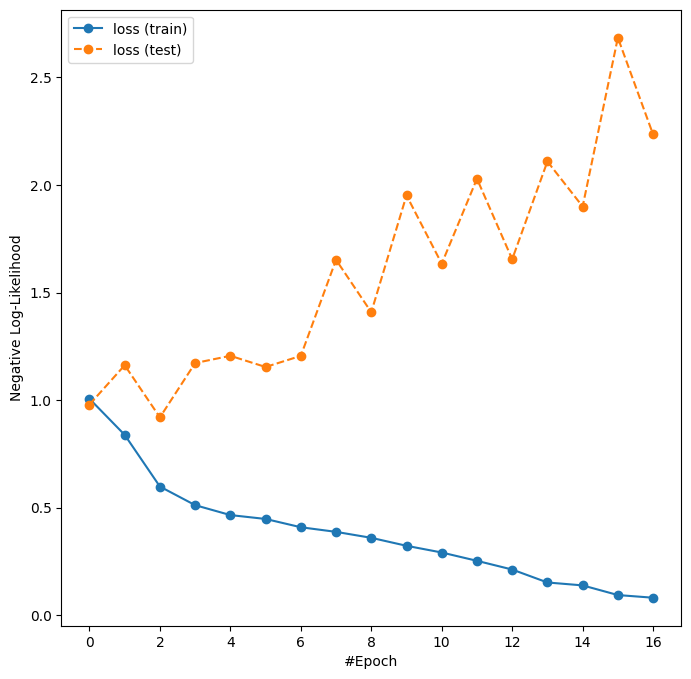

In [78]:

plt.figure(figsize=(8, 8))

plt.plot(train_losses, marker='o', label='loss (train)')
plt.plot(test_losses, marker='o', linestyle='dashed', label='loss (test)')

plt.xlabel('#Epoch')
plt.ylabel('Negative Log-Likelihood')

plt.legend()
plt.show()


In [79]:
# resume best model
net.load_state_dict(best_params)
best_accuracy

69.71153846153847